<span style="color: red;">Requirement when running in Goolge Colab</span>

In [ ]:
!pip install diffusers

#  Chapter 2 - Breakdown

You've probably seen the image describing the architecture behind Stable Diffusion. In this chapter, we attempt to extract the internal sampling process that happens within the Diffusers pipeline. This breakdown will align closer to the main architecture for better understanding and will be utilized later for fine-tuning or prompt2prompt editing of images.

- **VAE (Variational Auto-Encoder)**

    The VAE handles the pixel space of the image. It consists of two parts:

    - Encoder (E): *Compresses the image into a lower-dimensional latent space.*
    - Decoder (D): *Reconstructs the image from the latent representation. The VAE enables efficient processing by working in this compressed latent space.*


- **UNET and Scheduler**
    
    These components operate in the latent space:

    - Scheduler: *Also known as the Diffusion Process or denoising step. It guides the gradual transformation from noise to image.*
    - UNET: *Predicts the noise in the current state of the image, allowing for its removal.*


- **Tokenizer and Text Encoder**
    
    These handle the text input (prompt):

    - Tokenizer: *Converts the text prompt into tokens (numerical representations).*
    - Text Encoder: *Transforms these tokens into a format that can guide the image generation process*



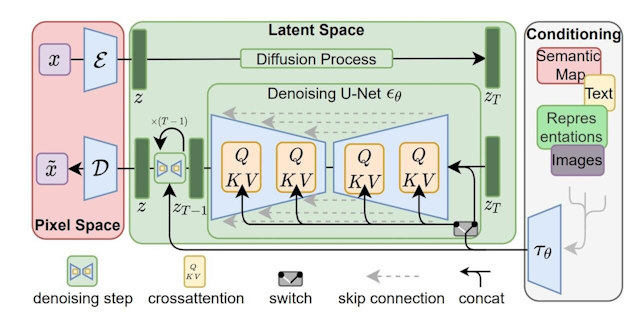

Importing the relevant libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import diffusers
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

This time around instead of loading the pretrained pipeline altogther we will load individual elements one by one in order explained above, all of this would be equivalent to pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16) that was done in the previous chapter

In [ ]:
model_id = "stabilityai/stable-diffusion-2-1-base"

vae = AutoencoderKL.from_pretrained(
    model_id, subfolder="vae", revision=None, variant="fp16"
).to("cuda")


unet = UNet2DConditionModel.from_pretrained(
    model_id, subfolder="unet", revision=None, variant="fp16"
).to("cuda")
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")


tokenizer = CLIPTokenizer.from_pretrained(
    model_id, subfolder="tokenizer", revision=None, variant="fp16"
)
text_encoder = CLIPTextModel.from_pretrained(
    model_id, subfolder="text_encoder", revision=None, variant="fp16"
).to("cuda")


now we have to manually tokenise our prompt and encode it with our text encoder implementing Conditiong section, generating $\tau_\theta$

In [ ]:
prompt = "A photo of a woman, straight hair, light blonde and pink hair, smiling expression, grey background"

text_inputs = tokenizer(
                prompt,
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            ).input_ids
prompt_embeds = text_encoder(text_inputs.to("cuda"), attention_mask=None)[0]

Generate a random lantet noise based of the unet config sample size ($\mathbb{Z}_T$)

In [ ]:
latents = torch.randn((1, unet.in_channels, unet.config.sample_size, unet.config.sample_size), generator=torch.Generator().manual_seed(220)).to("cuda")

In the previous chapter the pipeline runs inference 50 times and that's what we will be doing by providing the latent and the prompt to the unet

![image.png](attachment:image.png)

and then providing the unet output to the scheduler for the denoising step

![image.png](attachment:image.png)

In [ ]:
num_inference_steps = 50
scheduler.set_timesteps(num_inference_steps, device="cuda")
timesteps = scheduler.timesteps

with torch.no_grad():
    for i, t in tqdm(enumerate(timesteps), total=len(timesteps), desc="Inference steps"):

        noise_pred = unet(
            latents,
            t,
            encoder_hidden_states=prompt_embeds,
            cross_attention_kwargs=None,
            return_dict=False,
        )[0]

        latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]

And afterwards we decode the latent back to the Pixel Space and normalise the output to display the image

![image.png](attachment:image.png)

In [ ]:
with torch.no_grad():
    image = vae.decode(latents / vae.config.scaling_factor, return_dict=False)[0]
    image_np = image.squeeze(0).float().permute(1,2,0).detach().cpu()
    image_np = image_np - image_np.min()
    image_np = image_np / image_np.max()

The results of this process would be not as good as the image generated in the previous chapter, this is due to a key missing component of the the sampling process which will be explained in the next chapter

In [ ]:
plt.imshow(image_np)